In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from acq import UCB, EI, PI, KG, find_next_batch
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('../')
sys.path.append("../GaussianProcess")
import GaussianProcess.kernel as kernel
from cigp import CIGP_withMean

C:\Users\Fillip\AppData\Roaming\Python\Python36\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define the objective function
This objective function represents a simple sum of sine functions. The goal is to demonstrate a basic mathematical function that exhibits periodic behavior with different frequencies. The input 'x' is the variable at which the sine functions are evaluated, and the result is the sum of sin(x) and sin(2x).

In [2]:
def objective_function(x):
    # Simple sum of sine functions for demonstration
    return torch.sin(x)+torch.sin(2*x)

## Initialize prior knowledge with 5 random points

In [3]:
input_dim = 1
num_initial_points = 5
train_x = torch.rand(num_initial_points, input_dim) * 10  # Random points in [0, 10] for each dimension
train_y = objective_function(train_x).reshape(-1,1)

# Initialize the surrogate model
This code initializes a surrogate model for Bayesian optimization. The surrogate model (CIGP_withMean) is equipped with a chosen kernel (ARDKernel) to capture the underlying patterns in the data.  The Adam optimizer is then set up to optimize the model's parameters during the training process. 

In [4]:
kernel1 = kernel.ARDKernel(1)
# kernel1 = kernel.MaternKernel(1)
# kernel1 = kernel.LinearKernel(1,-1.0,1.)
# kernel1 = kernel.SumKernel(kernel.LinearKernel(1), kernel.MaternKernel(1))
model = CIGP_withMean(1, 1, kernel=kernel1, noise_variance=2.)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-2)

# Define the mean and variance functions for acq function
The defined mean and variance functions extract the predictive mean and variance from the trained surrogate model (model) when provided with input points (X). These functions are crucial components in the computation of acquisition functions, such as the Upper Confidence Bound (UCB), and are used to guide the selection of the next point for evaluation in the Bayesian optimization process.

In [5]:
def mean_function(X):
    model.eval()
    with torch.no_grad():
        mean, _ = model.forward(train_x, train_y, X)
        return mean

def variance_function(X):
    model.eval()
    with torch.no_grad():
        _, var = model.forward(train_x, train_y, X)
        return var

# Initialize acq function
The code snippet initializes different acquisition functions for Bayesian optimization.

In [6]:
ucb = UCB(mean_function, variance_function, kappa=5)
pi = PI(mean_function, variance_function)
ei = EI(mean_function, variance_function)
kg = KG(mean_function, variance_function, num_fantasies=10)
best_y = []
# use it to remember the key iteration
key_iterations = [2,4,5,6,8,10]
predictions = []
iteration_label = True


# Bayesian optimization loop
The key iterations allow monitoring the model's behavior and predictions at specific points during the optimization process. The overall process aims to iteratively improve the surrogate model and select points for evaluation that are expected to yield the best objective values.

In [7]:
# Bayesian optimization loop
bounds = np.array([[0, 10]] * input_dim)
for iteration in range(10):  # Run for 5 iterations

    for i in range(100):
        optimizer.zero_grad()
        loss = -model.log_likelihood(train_x, train_y)
        loss.backward()
        optimizer.step()
        print('iter', i, 'nll:{:.5f}'.format(loss.item()))


    batch_points = find_next_batch(ucb, bounds, batch_size=1, n_samples=500, f_best=train_x[np.argmax(train_y)])
    # batch_points = ei.find_next_batch(bounds, batch_size=1, n_samples=1000, f_best=train_x[np.argmax(train_y)])
    #find_next_batch(acq)
    batch_points = torch.tensor(batch_points).float()

    # Evaluate the objective function
    new_y = objective_function(batch_points.squeeze()).reshape(-1,1)

    # Update the model
    train_x = torch.cat([train_x, batch_points])
    train_y = torch.cat([train_y, new_y])
    # Store the best objective value found so far
    best_y.append(new_y.max().item())
    # Visualization

    # 在关键迭代时保存模型预测
    if (iteration + 1) in key_iterations:
        model.eval()
        fixed_dims = torch.full((1, input_dim - 1), 5.0)  # Example: set them to the midpoint (5.0)
        test_points = torch.linspace(0, 10, 100)
        test_X = torch.cat((test_points.unsqueeze(1), fixed_dims.expand(test_points.size(0), -1)), 1)
        true_y = objective_function(test_X)

        with torch.no_grad():
            pred_mean, pred_std = model.forward(train_x, train_y, test_X)
            predictions.append((pred_mean, pred_std))


d:\ANACONDA\envs\water\lib\site-packages\torch\autograd\__init__.py:156: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


iter 0 nll:8.64078
iter 1 nll:8.56939
iter 2 nll:8.49719
iter 3 nll:8.42416
iter 4 nll:8.35031
iter 5 nll:8.27563
iter 6 nll:8.20011
iter 7 nll:8.12378
iter 8 nll:8.04663
iter 9 nll:7.96867
iter 10 nll:7.88995
iter 11 nll:7.81047
iter 12 nll:7.73029
iter 13 nll:7.64945
iter 14 nll:7.56803
iter 15 nll:7.48608
iter 16 nll:7.40372
iter 17 nll:7.32107
iter 18 nll:7.23827
iter 19 nll:7.15553
iter 20 nll:7.07311
iter 21 nll:6.99139
iter 22 nll:6.91084
iter 23 nll:6.83211
iter 24 nll:6.75607
iter 25 nll:6.68382
iter 26 nll:6.61684
iter 27 nll:6.55703
iter 28 nll:6.50678
iter 29 nll:6.46905
iter 30 nll:6.44717
iter 31 nll:6.44432
iter 32 nll:6.46057
iter 33 nll:6.46911
iter 34 nll:6.46989
iter 35 nll:6.46306
iter 36 nll:6.44985
iter 37 nll:6.43230
iter 38 nll:6.41260
iter 39 nll:6.39261
iter 40 nll:6.37367
iter 41 nll:6.35656
iter 42 nll:6.34167
iter 43 nll:6.32910
iter 44 nll:6.31880
iter 45 nll:6.31072
iter 46 nll:6.30471
iter 47 nll:6.30049
iter 48 nll:6.29749
iter 49 nll:6.29498
iter 50 nl

d:\ANACONDA\envs\water\lib\site-packages\ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


iter 83 nll:7.45700
iter 84 nll:7.45698
iter 85 nll:7.45695
iter 86 nll:7.45693
iter 87 nll:7.45691
iter 88 nll:7.45689
iter 89 nll:7.45687
iter 90 nll:7.45685
iter 91 nll:7.45683
iter 92 nll:7.45682
iter 93 nll:7.45680
iter 94 nll:7.45678
iter 95 nll:7.45676
iter 96 nll:7.45675
iter 97 nll:7.45673
iter 98 nll:7.45671
iter 99 nll:7.45670
Number of parameters in forward function: 1
iter 0 nll:8.74298
iter 1 nll:8.74173
iter 2 nll:8.74180
iter 3 nll:8.74190
iter 4 nll:8.74078
iter 5 nll:8.74018
iter 6 nll:8.74022
iter 7 nll:8.73933
iter 8 nll:8.73845
iter 9 nll:8.73828
iter 10 nll:8.73756
iter 11 nll:8.73662
iter 12 nll:8.73630
iter 13 nll:8.73567
iter 14 nll:8.73479
iter 15 nll:8.73441
iter 16 nll:8.73382
iter 17 nll:8.73304
iter 18 nll:8.73266
iter 19 nll:8.73208
iter 20 nll:8.73142
iter 21 nll:8.73107
iter 22 nll:8.73049
iter 23 nll:8.72998
iter 24 nll:8.72964
iter 25 nll:8.72909
iter 26 nll:8.72871
iter 27 nll:8.72835
iter 28 nll:8.72788
iter 29 nll:8.72759
iter 30 nll:8.72721
iter 3

# plot the picture
This visualization helps to understand how well the Gaussian Process model captures the true function and how uncertainty evolves as more samples are acquired during the optimization process.

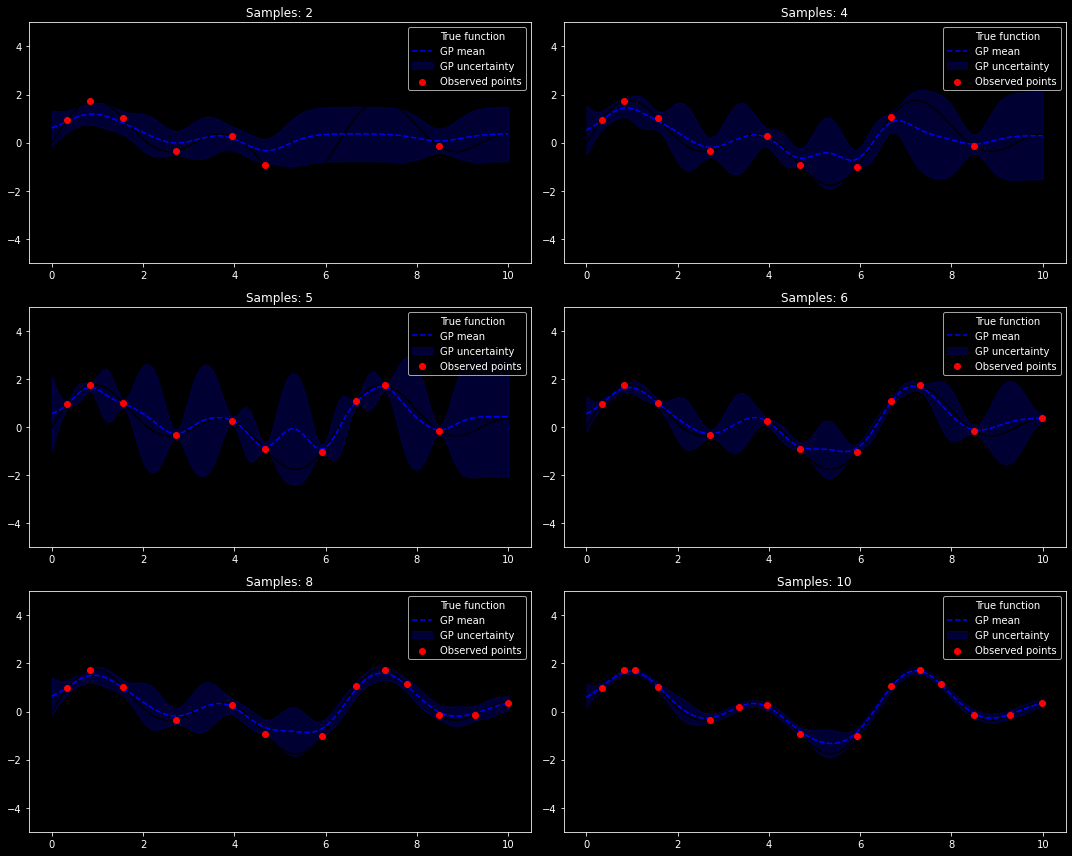

In [8]:
# 绘制子图
plt.figure(figsize=(15, 12))
for i, (pred_mean, pred_std) in enumerate(predictions):
    plt.subplot(3, 2, i+1)
    plt.ylim(-5, 5)
    plt.plot(test_points.numpy(), true_y.numpy(), 'k-', label='True function')
    plt.plot(test_points.numpy(), pred_mean.numpy(), 'b--', label='GP mean')
    plt.fill_between(test_points.numpy().reshape(-1),
                     (pred_mean - 2 * pred_std).numpy().reshape(-1),
                     (pred_mean + 2 * pred_std).numpy().reshape(-1),
                     color='blue', alpha=0.2, label='GP uncertainty')

    observed_x = train_x[:, 0].numpy()  # Only the first dimension for all observed points
    observed_y = train_y.numpy()
    plt.scatter(observed_x[:num_initial_points+key_iterations[i]], observed_y[:num_initial_points+key_iterations[i]], c='r', zorder=3, label='Observed points')
    plt.title(f'Samples: {key_iterations[i]}')
    plt.legend()

plt.tight_layout()
plt.show()
